## Demo TAIDE operating principle by Su-Yung Tsai
### modified from NTU prof. 李宏毅 genAi and deeplearning.ai

## Activate GPU
Since you will fine-tune a model, you **MUST** activate GPU so that this homework can be done in reasonable time (1~2 hrs)

### **MUST READ**:

Colab does **NOT** guarantee the GPU access for free user ([ref](https://research.google.com/colaboratory/faq.html#idle-timeouts)). It is possible you get an message saying "Cannot connect to GPU backend" which means there are no enough GPU resources for you now. When this happens, you may need to **wait for one (or more) day or login different Google account to do the homework**.

### Enable GPU

1. Click on "Runtime" (or "執行階段") in the header.
2. Click on "Change runtime type" (or "變更執行階段類型") in the drop menu.
3. Select "T4 GPU" and save. (You can select "A100 GPU" or "V100 GPU" if you have Colab Pro)
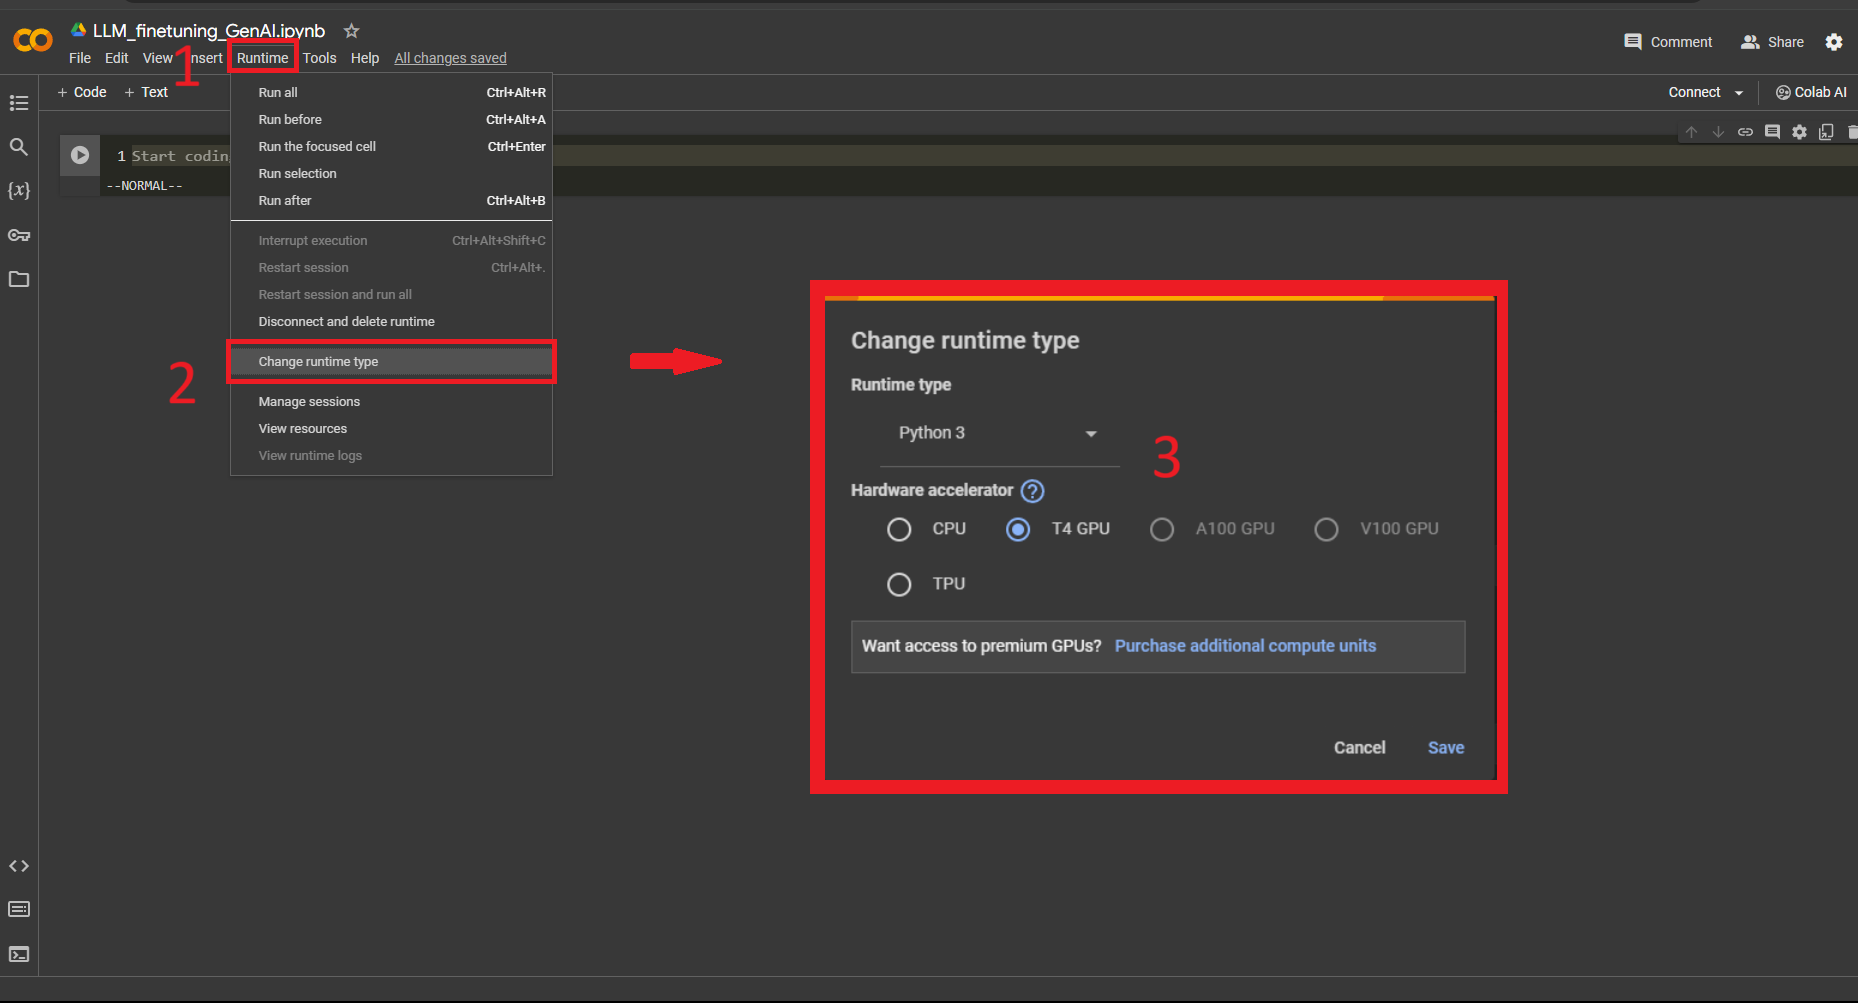

## Mount Google Drive
You **MUST** mount your Google Drive so that the  results can be saved on it.

To mount Google Drive, please follow these steps:

1. Run the next cell.
2. Click on "Connect to Google Drive". (There should be a window popup)
3. Sign in your account and give permission.

The following code block takes about **1** minutes to run, but it may vary depending on the condition of Colab and Google Drive.

In [36]:
!pwd

/content


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/LLM/TAIDE_OA_training_set
!cp .env  /content
%cd /content/

/content/drive/MyDrive/Colab Notebooks/LLM/TAIDE_OA_training_set
/content


In [3]:
!pip install python-dotenv

In [4]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

## Install Packages
We install and import some well-written packages created by others to facilitate the fine-tuning process.

In [ ]:
""" It is recommmended NOT to change codes in this cell """

!pip install bitsandbytes
!pip install datasets==2.10.1
!pip install transformers==4.38.2
!pip install peft==0.9.0
!pip install sentencepiece==0.1.99
!pip install -U accelerate==0.28.0
!pip install colorama==0.4.6

In [ ]:
import time

In [6]:
import os
import sys
import argparse
import json
import warnings
import logging
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import bitsandbytes as bnb
from datasets import load_dataset, load_from_disk
import transformers, datasets
from peft import PeftModel
from colorama import *

from tqdm import tqdm
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import GenerationConfig
from peft import (
    prepare_model_for_int8_training,
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training
)

## How to load an LLM from HuggingFace?

In [ ]:
""" It is recommmended NOT to change codes in this cell """
#model_name = "MediaTek-Research/Breeze-7B-Instruct-v0_1"

access_token = os.getenv('access_token')
#model_name = "taide/TAIDE-LX-7B"
#model_name = "taide/TAIDE-LX-7B-Chat"
model_name = "taide/Llama3-TAIDE-LX-8B-Chat-Alpha1"

nf4_config =BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch.bfloat16
)


# 從指定的模型名稱或路徑載入預訓練的語言模型

original_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token=access_token,
    quantization_config=nf4_config,
    device_map={'': 0},  # 設定使用的設備，此處指定為 GPU 0
)


# 創建 tokenizer 並設定結束符號 (eos_token)
logging.getLogger('transformers').setLevel(logging.ERROR)
tokenizer = AutoTokenizer.from_pretrained(
    model_name,token=access_token,
    #add_eos_token=True,
    #cache_dir=cache_dir,
    #quantization_config=nf4_config
    #use_fast=False
)
tokenizer.pad_token = tokenizer.eos_token
original_model.config.use_cache=True

## 玩文字接龍

In [8]:
gene= GenerationConfig(
    do_sample=False,
    #temperature=0.1,
    num_beams=1,
    #top_p=0.3,
    #no_repeat_ngram_size=3,
    pad_token_id=2,
)

In [9]:
prompt="I love to study AI, because"
    # 將提示文本轉換為模型所需的數字表示形式
print("prompt :",prompt)
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
inplen=input_ids.shape[-1]
print('ii:',input_ids)
generation_output = original_model.generate(
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=20,
    )
    # 將生成的回覆解碼並印出
print("oo: ",type(generation_output))
print("--------------> \n\n")
ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
    #print(ss)
    #print("--------------\n\n")
print(tokenizer.decode(ss[(inplen+0):]))

prompt : I love to study AI, because
ii: tensor([[   40,  3021,   311,  4007, 15592,    11,  1606]], device='cuda:0')
oo:  <class 'transformers.generation.utils.GenerateDecoderOnlyOutput'>
--------------> 


 it's a field that's constantly evolving and improving. There are so many interesting problems to solve,


In [10]:
tokenizer.eos_token

'<|end_of_text|>'

In [11]:
type(original_model)

transformers.models.llama.modeling_llama.LlamaForCausalLM

In [ ]:
original_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

In [ ]:
original_model.config.max_position_embeddings

8192

#  transforms input tokens (with indices from 0 to 128,255) into dense 4096-dimensional vectors.

In [12]:
""" It is recommmended NOT to change codes in this cell """

seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

##  Testing 生成 claim/.prior comparison
The fine-tuning process is done. We then want to test whether our model can do the task that we wanted it to do before but failed.

In [15]:
## 生成推理用的提示文本，包含指令和輸入（若有）
def generate_prompt_inference(claim=None, prior_art=None):
        return f"""### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
{claim}
### 輸入引證:
{prior_art}
### 回覆:
"""

We need to first load the fine-tuned model for checkpoint we saved.

The following code block takes about **2** minutes to run if you use the default setting, but it may vary depending on the condition of Colab.

In [16]:
Claim_stick="""一種智慧型盲人拐杖，具有一把手及一桿體，其特徵在於： 該桿體設有一水平測距裝置及一垂直測距裝置，該水平測距裝置係用以偵測其與前方一障礙物間之水平距離，該垂直測距裝置係用以偵測其與地面間之垂直距離；以及 該把手或該桿體內設有一控制單元及一警示裝置，該控制單元係用以在所述水平距離小於一第一預設值時產生一警示致能信號，並在所述垂直距離大於一第二預設值時亦產生該警示致能信號，且該警示裝置係依該警示致能信號之控制發出一警示信號，俾以在一盲人依該拐杖探路之過程中，能及時發現前方之障礙物或坑洞。
"""

blind_doc1="[0023] 本創作之供視障者使用的拐杖，\
係包括一拐杖本體、至少一超音波感測模組、至少一發光警示器、至少一聲音警示器以及一電源供應組。\
為利於說明，於本創作所揭示的圖式及以下的說明中皆係以一超音波感測模組、一發光警示器、一聲音警示器作為實施例，\
但本創作並不以一超音波感測模組、一發光警示器、一聲音警示器為限制。"
blind_doc2="[0024] 其中，超音波感測模組、發光警示器、聲音警示器以及電源供應組皆係設於拐杖本體上；\
而且，電源供應組供應超音波感測模組、發光警示器、聲音警示器電源。"
blind_doc3="[0025] 其中，超音波感測模組包括一發射器與一接收器，\
係由發射器發射超音波信號，該超音波信號因前方障礙物阻擋而反彈回傳且為接收器接收後，\
超音波感測模組便會根據從發射到接收所需的時間計算得知障礙物與視障者本身之間的直線距離，並因此得到一距離信號。"
blind_doc4="[0026] 發光警示器，為可多色發光的發光源，較佳為：該發光源包括至少一個LED，且該LED為多色發光LED；\
該超音波感測模組在計算得到該距離信號後便會送至發光警示器，令發光警示器根據障礙物與視障者的直線距離的長短顯示不同顏色的光源，\
供警示其他用路人手持本創作之拐杖的視障者的位置。"
blind_doc5="[0027] 聲音警示器，該超音波感測模組在計算得到該距離信號後也會送至聲音警示器，\
令聲音警示器根據障礙物與視障者的直線距離的長短發出不同音階或音效的警示聲響，\
以提醒手持本創作之拐杖的視障者其前方有障礙物。"
blind_doc6="[0028] 當視障者使用本創作之拐杖行走時，超音波感測模組便開始感測前方路況，\
即，超音波感測模組之發射器持續發出超音波信號，而在前方有障礙物或行人出現並且進入超音波感測模組的感測範圍後，\
發射器發射的超音波信號將因前方障礙物阻擋而反彈回傳並為接收器接收，\
接著超音波感測模組根據該超音波信號從發射到接收所需的時間計算得知障礙物與視障者本身之間的直線距離，以得到一距離信號，\
此一距離訊號再送至發光警示器與聲音警示器，\
而發光警示器便會依據障礙物與視障者間的距離顯示不同顏色的光源，\
同時聲音警示器也同樣依據障礙物與視障者間的距離發出不同音階或音效的警示聲響，\
以達到一方面以不同音階或音效的警示聲響通知視障者前方障礙物與自身之間的距離，另一方面也提醒其他用路人注意視障者，提高視障者用路時的安全性。"
blind_doc=blind_doc1+blind_doc2+blind_doc3+blind_doc4+blind_doc5+blind_doc6

In [17]:
tt=generate_prompt_inference(claim=Claim_stick,prior_art=blind_doc)
print(tt)

### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種智慧型盲人拐杖，具有一把手及一桿體，其特徵在於： 該桿體設有一水平測距裝置及一垂直測距裝置，

##Before fine-tuning

In [18]:
# 設定模型推理時需要用到的decoding parameters
#max_len = 4000
generation_config = GenerationConfig(
    do_sample=False,
    #temperature=0.1,
    num_beams=1,
    #top_p=0.3,
    #no_repeat_ngram_size=3,
    pad_token_id=2,
)
""" It is recommmended NOT to change codes in this cell """
#CUTOFF_LEN = 728  # 設定文本截斷的最大長度

# 進行生成回覆的評估
def analyze_claim(  claim, prior, verbose=True, gene=generation_config,  max_len=5000):
    #prompt=generate_prompt_inference(instruct3,input1,input2)
    prompt=generate_prompt_inference(claim, prior)
    # 將提示文本轉換為模型所需的數字表示形式
    print("prompt :",prompt)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
    inplen=input_ids.shape[-1]
    print("maxlen:",max_len)
    generation_output = original_model.generate(
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_len,
    )
    # 將生成的回覆解碼並印出
    print("oo: ",type(generation_output))
    print("--------------> \n\n")
    ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
    #print(ss)
    #print("--------------\n\n")
    return tokenizer.decode(ss[(inplen+0):])
    #print("<--------------\n\n")
    #print(len(generation_output.scores))
    #print(generation_output.scores[0].shape)
    #last_logits = generation_output.scores[0][0,:]
    #print(last_logits)
    #next_token_id = last_logits.argmax()
    #print('next: ',next_token_id)
    #print('\n')
    #last_2_logits = generation_output.scores[1][0,:]
    #print(last_2_logits)
    #next_2_token_id = last_2_logits.argmax()
    #print('next 2: ',next_2_token_id)

    #for s in generation_output.sequences:
    #    output = tokenizer.decode(s)
    #    output = output.split("[/INST]")[1].replace("</s>", "").replace("<s>", "").replace("Assistant:", "").replace("Assistant", "").strip()
    #    if (verbose):
    #        print(output)
    #return ss

In [13]:
claim2="""一種具備觸控操作之飲水機，其包含：
一主體；
一出水閥，設置於所述主體上；
一觸控面板，設置於所述主體上，用以接受使用者操作指令；
以及一控制模組，電性連接所述觸控面板與出水閥，以根據所述操作指令控制所述出水閥開啟或關閉。
"""
prior2="""CN106789012A 揭露一種具觸控控制功能的飲水機，包含一機體本體、一電子觸控面板與一控制電路，該觸控面板設置於機體表面，可接收使用者輸入指令，並透過控制電路控制飲水閥的開啟與關閉。該飲水閥設置於機體出水口處。
"""

In [19]:
print(analyze_claim(claim2,   prior2))

prompt : ### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種具備觸控操作之飲水機，其包含：
一主體；
一出水閥，設置於所述主體上；
一

In [14]:
claim1="""一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。
"""
prior1="""TW2017011223A 揭露一種筆記型電腦裝置，包括一顯示器與一主機本體，該顯示器與主機本體鉸接連接，主機本體內部設有一風扇模組，該風扇模組包含一散熱風扇與一導風通道，以排除主機本體內之熱氣。
"""

In [20]:
print(analyze_claim(claim1,   prior1))

prompt : ### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；


In [21]:
print(Claim_stick)

一種智慧型盲人拐杖，具有一把手及一桿體，其特徵在於： 該桿體設有一水平測距裝置及一垂直測距裝置，該水平測距裝置係用以偵測其與前方一障礙物間之水平距離，該垂直測距裝置係用以偵測其與地面間之垂直距離；以及 該把手或該桿體內設有一控制單元及一警示裝置，該控制單元係用以在所述水平距離小於一第一預設值時產生一警示致能信號，並在所述垂直距離大於一第二預設值時亦產生該警示致能信號，且該警示裝置係依該警示致能信號之控制發出一警示信號，俾以在一盲人依該拐杖探路之過程中，能及時發現前方之障礙物或坑洞。



In [23]:
print(analyze_claim(Claim_stick,   blind_doc))

prompt : ### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種智慧型盲人拐杖，具有一把手及一桿體，其特徵在於： 該桿體設有一水平測距裝置

In [22]:
print(Claim_stick)

一種智慧型盲人拐杖，具有一把手及一桿體，其特徵在於： 該桿體設有一水平測距裝置及一垂直測距裝置，該水平測距裝置係用以偵測其與前方一障礙物間之水平距離，該垂直測距裝置係用以偵測其與地面間之垂直距離；以及 該把手或該桿體內設有一控制單元及一警示裝置，該控制單元係用以在所述水平距離小於一第一預設值時產生一警示致能信號，並在所述垂直距離大於一第二預設值時亦產生該警示致能信號，且該警示裝置係依該警示致能信號之控制發出一警示信號，俾以在一盲人依該拐杖探路之過程中，能及時發現前方之障礙物或坑洞。



##After fine-tuning

In [24]:
#model_name = "/content/taide_7b"
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [25]:
%cd /content/drive/MyDrive/NNmodel

!cp   OA_0607_1.tar   /content/

%cd /content/

!tar xvf OA_0607_1.tar

/content/drive/MyDrive/NNmodel
/content
./OA_0607_1/
./OA_0607_1/adapter_config.json
./OA_0607_1/README.md
./OA_0607_1/adapter_model.safetensors


In [26]:
ckpt_name = "./OA_0607_1/"
# 從指定的 checkpoint 載入模型權重
# adapter_name (str, optional, defaults to "default") — The name of the adapter to be loaded. This is useful for loading multiple adapters.
pmodel = PeftModel.from_pretrained(original_model, ckpt_name,adapter_name='OAgen', device_map={'': 0})

In [27]:
# 設定模型推理時需要用到的decoding parameters
#max_len = 4000
generation_config = GenerationConfig(
    do_sample=False,
    temperature=0.5,
    #num_beams=1,
    #top_p=0.95,                   # 或 0.9（控制隨機性範圍）
    #no_repeat_ngram_size=3,       # 防止句子中詞彙重複
    #top_p=0.3,
    #no_repeat_ngram_size=3,
    pad_token_id=2,
)
""" It is recommmended NOT to change codes in this cell """
#CUTOFF_LEN = 728  # 設定文本截斷的最大長度

# 進行生成回覆的評估
def analyze_claim(  claim, prior, verbose=True, gene=generation_config,  max_len=5000):
    #prompt=generate_prompt_inference(instruct3,input1,input2)
    prompt=generate_prompt_inference(claim, prior)
    # 將提示文本轉換為模型所需的數字表示形式
    print("prompt :",prompt)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].cuda()
    # 使用模型進行生成回覆
    #print('input leng:\n',input_ids.shape)
    #print('input leng:\n',input_ids.shape[-1])
    #print("input_ids go:",input_ids)
    inplen=input_ids.shape[-1]
    print("maxlen:",max_len)
    generation_output = pmodel.generate(
        input_ids=input_ids,
        generation_config=gene,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=max_len,
    )
    # 將生成的回覆解碼並印出
    #print("--------------> \n\n")
    ss=generation_output.sequences[0]
    #print(ss[(inplen+1):])
    #print(ss)
    #print("--------------\n\n")
    return tokenizer.decode(ss[(inplen+0):])
    #print("<--------------\n\n")
    #print(len(generation_output.scores))
    #print(generation_output.scores[0].shape)
    #last_logits = generation_output.scores[0][0,:]
    #print(last_logits)
    #next_token_id = last_logits.argmax()
    #print('next: ',next_token_id)
    #print('\n')
    #last_2_logits = generation_output.scores[1][0,:]
    #print(last_2_logits)
    #next_2_token_id = last_2_logits.argmax()
    #print('next 2: ',next_2_token_id)

    #for s in generation_output.sequences:
    #    output = tokenizer.decode(s)
    #    output = output.split("[/INST]")[1].replace("</s>", "").replace("<s>", "").replace("Assistant:", "").replace("Assistant", "").strip()
    #    if (verbose):
    #        print(output)
    #return ss

## 是否正確分出差異為簡單變更

In [28]:
print(analyze_claim(Claim_stick,   blind_doc))

prompt : ### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種智慧型盲人拐杖，具有一把手及一桿體，其特徵在於： 該桿體設有一水平測距裝置

In [29]:
print(analyze_claim(claim2,   prior2))

prompt : ### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種具備觸控操作之飲水機，其包含：
一主體；
一出水閥，設置於所述主體上；
一

In [34]:
print(claim2)

一種具備觸控操作之飲水機，其包含：
一主體；
一出水閥，設置於所述主體上；
一觸控面板，設置於所述主體上，用以接受使用者操作指令；
以及一控制模組，電性連接所述觸控面板與出水閥，以根據所述操作指令控制所述出水閥開啟或關閉。



In [35]:
print(prior2)

CN106789012A 揭露一種具觸控控制功能的飲水機，包含一機體本體、一電子觸控面板與一控制電路，該觸控面板設置於機體表面，可接收使用者輸入指令，並透過控制電路控制飲水閥的開啟與關閉。該飲水閥設置於機體出水口處。



In [30]:
print(analyze_claim(claim1,   prior1))

prompt : ### 你是來自台灣智慧財產局之資深專利審查官。請根據下列「請求項」與「引證」撰寫正式審查意見，重點在判斷新穎性及進步性，並依據下列審酌原則與書寫格式規範完成。
一、審酌事項
1. 新穎性（Novelty）：請先完成新穎性判斷，不具新穎者，不須再討論進步性，直接撰寫審查意見。
2. 進步性（Inventive Step）：僅於具新穎性者才進行，若技術差異可由本領域技術人員輕易推知或組合，則不具進步性。
二、分析步驟如下，並在步驟三寫出審查意見公文
步驟一／新穎性分析
請比對請求項與引證技術，將每一項技術特徵分類為：
✅ 相同對應組成物：請求項技術特徵已於引證技術中揭示，且語意、功能與使用場景一致。
✅ 差異組成物：請求項技術特徵在引證技術中未見揭示，或雖有類似詞彙，但在**技術功能、結構、致能方式、或組合邏輯上具明顯差異**者。
⚠️ 注意：
請求項中的每一項技術特徵只能屬於一種分類（相同對應或差異）。
請明確標出所有「相同對應組成物」。
請明確標出所有「差異組成物」。
✴️ 新穎性判斷
請逐一檢視上述「差異組成物」，並對每一項作以下判斷：
若僅為文句差異、或為本領域技術人員可直接推得之已知替代作法，則不具新穎性。
若該特徵在結構、功能、作用方式上為引證所未揭示者，則具新穎性。
若請求項中**所有技術特徵**均為相同對應組成物，即本請求項不具新穎性，**不須進行進步性分析**，亦不需嘗試強行找出差異。
僅當有差異組成物具新穎性時，方可進入步驟二／進步性分析。若不具新穎者，直接撰寫審查意見。
步驟二／進步性分析
1. 檢視步驟一所示之「差異組成物」。
2. 分析：該差異是否屬本領域技術人員依據引證技術、以通常技術手段即可輕易完成之事項。
3. 判斷：若屬輕易可達，則不具進步性；否則視為具進步性。
步驟三／審查意見撰寫格式
1. **必須完整照抄請求項原文，語序不得變動、不得重寫句子。**
2. 對於「相同對應組成物」，請在該句之後標註對應來源，例如：**（引證技術段落[0025]）**
3. 對於「差異組成物」，必須使用 `<<...>>` 包住「差異組成物」，直接嵌入原句中，不可額外斷句。
4. 結尾總結審查結論，說明是否具新穎性與進步性及其原因。
### 輸入請求項:
一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；


In [33]:
print(claim1)

一種筆記型電腦裝置，其包含：
一顯示器；
一主機殼體，與所述顯示器鉸接連接；
以及一冷卻模組，設置於所述主機殼體內部，其中，所述冷卻模組包含一雙風扇配置，並對應於雙重進風口設計以提升散熱效率。

